# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [99]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics, LaTeXStrings
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value
using JLD2;

In [100]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

In [101]:
N = nv(g)  # number of individuals
T = 50     # final time
Δt = 0.02   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*Δt, ρ*Δt, floor(Int, T/Δt))

# prob. of being infected at time zero
for i in 1:N
   if i == 1
        sis.ϕ[i][1] .= [0.0, 1.0]   # node 1 is infected at time zero
    else
        sis.ϕ[i][1] .= [1.0, 0.0]   # all other nodes start as susceptible
    end
end

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [102]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [153]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
nsamples_mc = 10^5
sample!(sms, nsamples_mc);

SoftMargin sampling   1%|▏                               |  ETA: 3:32:42m24m

LoadError: InterruptException:

In [ ]:
# b_mc = marginals(sms)
# p29_mc = [bb[INFECTED] for bb in b_mc[29]];

In [ ]:
# discard monte carlo runs with no infected at final time
# this is to compare with the results in the paper
ids = findall(!all(x[:,end] .== SUSCEPTIBLE) for x in sms.X)
Xnew = sms.X[ids]
wnew = sms.w[ids]
sms_new = SoftMarginSampler(bp, Xnew, wnew)
b_mc = marginals(sms_new)
p_mc = [[bb[INFECTED] for bb in b] for b in b_mc]
p29_mc = [bb[INFECTED] for bb in b_mc[30]];

In [ ]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 0.2   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT))

# prob. of being infected at time zero
for i in 1:N
   if i == 1
        sis.ϕ[i][1] .= [0.0, 1.0]   # node 1 is infected at time zero
    else
        sis.ϕ[i][1] .= [1.0, 0.0]   # all other nodes start as susceptible
    end
end

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [ ]:
svd_trunc = TruncBond(5)   # maximum matrix size for SVD-based truncation
maxiter = 100
tol = 1e-4

# run MPBP
iters, cb = iterate!(bp; cb, svd_trunc, maxiter, tol);

In [ ]:
if iters < maxiter
    println("BP converged after $iters iterations")
else
    println("BP did not meet criteria for convergence after $maxiter iterations")
end

In [ ]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [ ]:
# compute marginals
b_bp = beliefs(bp)
p_bp = [[bb[INFECTED] for bb in b] for b in b_bp]
p29_bp = [bb[INFECTED] for bb in b_bp[30]];

In [ ]:
c_bp = autocovariances(bp);

In [ ]:
using ColorSchemes
function plot_autocovs(c, T; ΔT=1.0, kw...)
    us = 0:30:T
    cg = cgrad(:matter, length(us), categorical=true)
    ylabel = L"\langle x_{29}^t x_{29}^{t+\Delta t}\rangle-" * 
        L"\langle x_{29}^t\rangle\langle x_{29}^{t+\Delta t}\rangle"
    xlabel = L"\Delta t"
    pl = plot(;xlabel, ylabel, legend=:outertopright, 
        title="SIS karate club. λ = $λ, ρ = $ρ")
     
    for (j,u) in enumerate(us)
        plot!(pl, (u:-1:1).*ΔT, c[(0:u-1) .+ 1,u+1], label="t+Δt=$(Int(u*ΔT))", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  

In [ ]:
c_bp29 = map(x -> x > 1e-14 ? x : NaN, c_bp[30]);

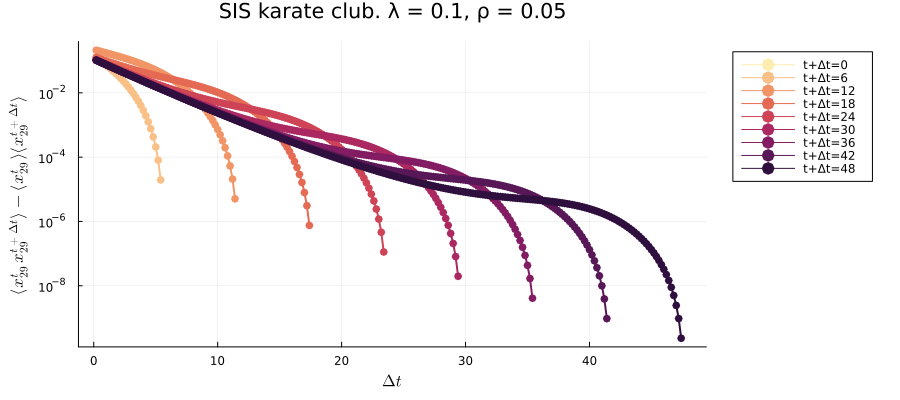

In [122]:
pl_autocov = plot_autocovs(c_bp29, floor(Int, T/ΔT); ΔT, yaxis=(:log10), 
    size=(900,400), margin=5Plots.mm)

## Comparison with other methods

In [ ]:
# cavity master equation
function cme!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])*sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-ϕ[t-1][id])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# dynamic message passing
function dmp!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-r[t-1][i])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# individual based mean field
function ibmf!(r, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(r[t-1][src(e)] for e in inedges(g, i); init=0.0)
        end
    end
    nothing
end

In [ ]:
Δt = 0.02 #ΔT
Tdisc = floor(Int, T/Δt)

ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]

r[1][1] = 1

for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

In [ ]:
r_cme = deepcopy(r)
ϕ_cme = deepcopy(ϕ)
cme!(r_cme, ϕ_cme, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_cme = [[rt[i] for rt in r_cme] for i in 1:N];

In [ ]:
r_dmp = deepcopy(r)
ϕ_dmp = deepcopy(ϕ)
dmp!(r_dmp, ϕ_dmp, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_dmp = [[rt[i] for rt in r_dmp] for i in 1:N];

In [ ]:
r_ibmf = deepcopy(r)
ibmf!(r_ibmf, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_ibmf = [[rt[i] for rt in r_ibmf] for i in 1:N];

In [155]:
Δt = 0.02

0.02

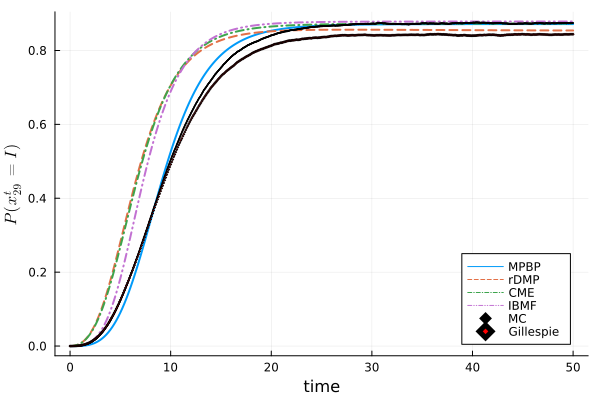

In [156]:
Plots.default(lw=2)

pl = plot(xlabel="time", xticks=0:10:T, ylabel="\$P(x_{29}^t=I)\$", legend=:bottomright)
plot!(pl, 0:ΔT:T, p29_bp, label="MPBP")
plot!(pl, 0:Δt:T, p_dmp[30], ls=:dash, label="rDMP")
plot!(pl, 0:Δt:T, p_cme[30], ls=:dashdot, label="CME")
plot!(pl, 0:Δt:T, p_ibmf[30], ls=:dashdotdot, label="IBMF")
# plot!(pl, 0:Δt:T, p_pbmf1[30], ls=:dashdotdot, label="PBMF1")
scatter!(pl, 0:Δt:T, value.(p29_mc), m=:diamond, ms=1, label="MC", c=:black)
plot!(pl, 0:0.1:T, av, label="Gillespie", m=:diamond, c=:red, st=:scatter, ms=1)

# ylims = (0.85,0.88)
# plot!(pl, xticks=T-5:1:T, ylims=ylims, xlims=(T-5,T),
#     inset=(1, bbox(0.5, 0.25, 0.45, 0.3)), subplot=2)
# plot!(pl[2], 0:ΔT:T, p29_bp, label="")
# plot!(pl[2], 0:Δt:T, p_dmp[30], ls=:dash, label="")
# plot!(pl[2], 0:Δt:T, p_cme[30], ls=:dashdot, label="")
# plot!(pl[2], 0:Δt:T, p_ibmf[30], ls=:dashdotdot, label="")
# scatter!(pl[2], 0:Δt:T, value.(p29_mc), m=:diamond, ms=3, label="", c=:black);

In [124]:
jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, Δt, p_bp, p_mc, p_dmp, p_cme, p_ibmf, c_bp,
    λ, ρ, svd_trunc);

In [125]:
using CavityTools

# Λ = contact network
# λ = rate of infection
# μ[i] = rate of recovery of I
# T = final time 
∂(g, i) = neighbors(g, i)

function simulate_queue_sis!(x, g, P0, λ, μ, T;
    stats=(t, i, x) -> println("$t $i $(x[i])"),
    Q=ExponentialQueue(N))

    N = length(P0)
    t = 0.0
    x .= false
    empty!(Q)
    for i = 1:N
        if rand() < P0[i]
            Q[i] = Inf
        end
    end
    while !isempty(Q)
        i, Δt = pop!(Q)
        t += Δt
        t > T && break
        x[i] = !x[i]
        stats(t, i, x)
        if x[i] == 1
            Q[i] = μ[i]
            for j in ∂(g, i)
                if x[j] == 0
                    Q[j] = j ∈ Q ? Q[j] + λ : λ
                end
            end
        elseif x[i] == 0
            s = 0.0
            for j in ∂(g, i)
                if x[j] == 0
                    if j ∈ Q
                        Q[j] -= λ
                    end
                else
                    s += λ
                end
            end
            Q[i] = s
        end
    end
    x
end


simulate_queue_sis! (generic function with 1 method)

In [126]:
N = nv(g)
μ = fill(ρ,N)
λ = λ
P0 = [p[1][2] for p in sis.ϕ]

34-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [154]:
function TrajectoryRecorder()
    v = Tuple{Float64,Int,Int}[]
    function stats(t, i, x)
        push!(v, (t,i,x[i]))
    end
end

q = TrajectoryRecorder();
x = fill(false, N);
Q = ExponentialQueue(N)
s = zeros(N)
nsamples = 10^5
Δt = 0.1
K = floor(Int, T/Δt) + 1
ni = zeros(Int, K)
av = zeros(K)
va = zeros(K)
for i=1:nsamples
    ni .= 0
    empty!(q.v)
    simulate_queue_sis!(x, sis.g, P0, λ, μ, T; stats = q, Q=Q)
#     if sum(x)>0
        for (t,j,x) in q.v
            if j == 30
                k = floor(Int, t/Δt) + 1
                @assert t <= T
                @assert k <= K
                ni[k] += 2x-1
            end
        end
#     end
    for k=2:length(ni)
        ni[k] += ni[k-1]
    end
    av .+= ni
    va .+= ni .^ 2

end
av ./= nsamples
va ./= nsamples
va .-= av .^ 2
[av sqrt.(va)]


501×2 Matrix{Float64}:
 1.0e-5   0.00316226
 1.0e-5   0.00316226
 4.0e-5   0.00632443
 9.0e-5   0.00948641
 0.00015  0.0122465
 0.00028  0.0167309
 0.00041  0.0202443
 0.00076  0.0275576
 0.00104  0.0322323
 0.00133  0.0364449
 0.00176  0.0419154
 0.00237  0.0486249
 0.00287  0.0534954
 ⋮        
 0.84293  0.363867
 0.84309  0.363716
 0.84367  0.363168
 0.8436   0.363234
 0.84376  0.363083
 0.84358  0.363253
 0.84354  0.363291
 0.84356  0.363272
 0.84388  0.362969
 0.844    0.362855
 0.84394  0.362912
 0.84394  0.362912

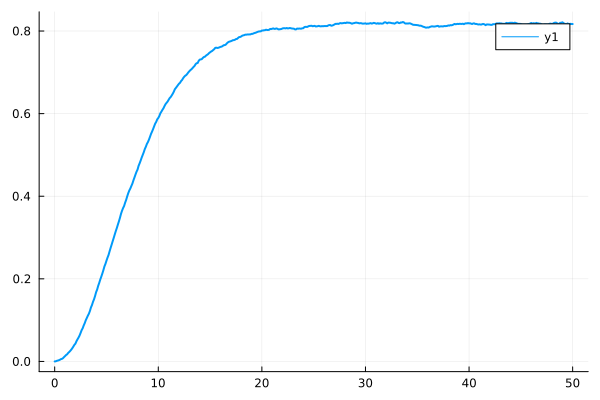

In [132]:
plot(0:Δt:T, av)